# DS300 Mini-Project - Differential Privacy via a Flask REST API
* **Name:** Jason C. Nucciarone
* **Email:** jcn23@psu.edu
* **Date:** 12/5/2021
* **Python version:** 3.10.0
* **Dataset Source:** https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/cfd2e743-8809-49be-90b6-0e22f453be23/download/public_150k_plus_211121.csv
* **Epsilon:** 0.1

### IMPORTANT INFO
Flask server must be running in order for API requests to work. Use the following to launch server before continuing:

```bash
# In root directory of project
pip install --user -r requirements.txt
python dfserver.py
```

## Setup

In [16]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
import requests
import sys
import warnings
from tabulate import tabulate
from typing import Tuple

# Global variables
TABLE_FORMAT = "presto"

# Silence warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


def pct_error(orig: float, priv: float) -> float:
    """
    Calculate the percent error of the noisy answer.

    :param orig: Original value.
    :param priv: Noisy value.
    :return: Percent error.
    """
    return np.abs(orig-priv)/orig*100.0


# Construct class to handle URL requests to web API
class RequestHandler:
    """ Class to function as go-between for API and Notebook. """
    def __init__(self, root_url: str, port: str) -> None:
        self._root_url = root_url
        self._port = port

    def execute(self, sql: str, dp_active=True) -> dict:
        """
        Query web server.

        :param sql: SQL query.
        :param dp_active: Toggle DP on or off - True = on - False = off
        """
        res = requests.get(self._url_builder((dp_active, sql)))
        
        if res.status_code != 200: 
            return None
        
        return res.json()

    def _url_builder(self, query: Tuple[bool, str]) -> str:
        """
        Construct query to web server.

        :param query: Unformatted SQL query with DP activated or not activated.
        :return: Formatted URL to query web server
        """
        sql = query[1].replace(" ", "+")

        if query[0] is True:
            dp_or_orig = "diff"

        else:
            dp_or_orig = "orig"

        return self._root_url + ":" + self._port + "/" + dp_or_orig + "/" + sql

    @property
    def info(self):
        """ Return info about database. """
        res = requests.get(self._root_url + ":" + self._port + "/info")

        if res.status_code != 200:
            return None

        return res.json()


# Initialize request handler
rh = RequestHandler("http://127.0.0.1", "5000")

## Info about PPP Loan Database

In [17]:
# Some basic data exploration to demonstrate API is work
db_info = rh.info

# Print out column names
headers=["", "Column Name"]
table = []
index = 0
for attr in db_info["attr_names"]:
    table.append([index, attr])
    index += 1

print(f"Attributes:\n\n{tabulate(table, headers, tablefmt=TABLE_FORMAT)}")

# Print out number of attributes
print(f"\nNumber of attributes: {db_info['columns']}")

# Print out number of records
print(f"\nNumber of records: {db_info['rows']}")

# Print if there is any missing values
print(f"\nMissing values: {db_info['missing_values']}")

Attributes:

    | Column Name
----+-----------------------------
  0 | LoanNumber
  1 | DateApproved
  2 | SBAOfficeCode
  3 | ProcessingMethod
  4 | BorrowerName
  5 | BorrowerAddress
  6 | BorrowerCity
  7 | BorrowerState
  8 | BorrowerZip
  9 | LoanStatusDate
 10 | LoanStatus
 11 | Term
 12 | SBAGuarantyPercentage
 13 | InitialApprovalAmount
 14 | CurrentApprovalAmount
 15 | UndisbursedAmount
 16 | FranchiseName
 17 | ServicingLenderLocationID
 18 | ServicingLenderName
 19 | ServicingLenderAddress
 20 | ServicingLenderCity
 21 | ServicingLenderState
 22 | ServicingLenderZip
 23 | RuralUrbanIndicator
 24 | HubzoneIndicator
 25 | LMIIndicator
 26 | BusinessAgeDescription
 27 | ProjectCity
 28 | ProjectCountyName
 29 | ProjectState
 30 | ProjectZip
 31 | CD
 32 | JobsReported
 33 | NAICSCode
 34 | Race
 35 | Ethnicity
 36 | UTILITIES_PROCEED
 37 | PAYROLL_PROCEED
 38 | MORTGAGE_INTEREST_PROCEED
 39 | RENT_PROCEED
 40 | REFINANCE_EIDL_PROCEED
 41 | HEALTH_CARE_PROCEED
 42 | DEBT_INTERE

## Utility of counting queries

In [18]:
count_query1 = "SELECT COUNT(*) FROM PPP WHERE BorrowerState='PA'"
count_query2 = "SELECT COUNT(*) FROM PPP WHERE LoanStatus='Exemption'"
count_query3 = "SELECT COUNT(*) FROM PPP WHERE ProjectCity='ANCHORAGE' AND JobsReported < 50"

# Original results
count_query1_result_orig = rh.execute(count_query1, False)
count_query2_result_orig = rh.execute(count_query2, False)
count_query3_result_orig = rh.execute(count_query3, False)

# DP results
count_query1_result_diff = rh.execute(count_query1)
count_query2_result_diff = rh.execute(count_query2)
count_query3_result_diff = rh.execute(count_query3)

# Display the Results
headers = ["Query", "Original Value", "Noisy Value", "Percent Error"]
table = [
    [1, count_query1_result_orig["result"], count_query1_result_diff["result"], pct_error(count_query1_result_orig["result"], count_query1_result_diff["result"])],
    [2, count_query2_result_orig["result"], count_query2_result_diff["result"], pct_error(count_query2_result_orig["result"], count_query2_result_diff["result"])],
    [3, count_query3_result_orig["result"], count_query3_result_diff["result"], pct_error(count_query3_result_orig["result"], count_query3_result_diff["result"])]
]
print(tabulate(table, headers, tablefmt=TABLE_FORMAT))

   Query |   Original Value |   Noisy Value |   Percent Error
---------+------------------+---------------+-----------------
       1 |            38537 |    38520.6    |       0.0426203
       2 |                0 |       48.7999 |     inf
       3 |              603 |      594.117  |       1.47313


## Utility of summation queries

In [19]:
sum_query1 = "SELECT SUM(PAYROLL_PROCEED) FROM PPP WHERE BusinessType='Corporation'"
sum_query2 = "SELECT SUM(HEALTH_CARE_PROCEED) FROM PPP WHERE Race='Unanswered'"
sum_query3 = "SELECT SUM(CurrentApprovalAmount) FROM PPP WHERE LoanStatus='Paid in Full'"

# Original results
sum_query1_result_orig = rh.execute(sum_query1, False)
sum_query2_result_orig = rh.execute(sum_query2, False)
sum_query3_result_orig = rh.execute(sum_query3, False)

# DP results
sum_query1_result_diff = rh.execute(sum_query1)
sum_query2_result_diff = rh.execute(sum_query2)
sum_query3_result_diff = rh.execute(sum_query3)

# Display the Results
headers = ["Query", "Original Value", "Noisy Value", "Percent Error"]
table = [
    [1, sum_query1_result_orig["result"], sum_query1_result_diff["result"], pct_error(sum_query1_result_orig["result"], sum_query1_result_diff["result"])],
    [2, sum_query2_result_orig["result"], sum_query2_result_diff["result"], pct_error(sum_query2_result_orig["result"], sum_query2_result_diff["result"])],
    [3, sum_query3_result_orig["result"], sum_query3_result_diff["result"], pct_error(sum_query3_result_orig["result"], sum_query3_result_diff["result"])]
]
print(tabulate(table, headers, tablefmt=TABLE_FORMAT))

   Query |   Original Value |   Noisy Value |   Percent Error
---------+------------------+---------------+-----------------
       1 |      2.09299e+11 |   2.09293e+11 |       0.0033047
       2 |      2.25661e+09 |   2.32791e+09 |       3.15971
       3 |      3.73362e+11 |   3.73423e+11 |       0.0165374


## Utility of average queries

In [20]:
avg_query1 = "SELECT AVG(InitialApprovalAmount) FROM PPP"
avg_query2 = "SELECT AVG(ForgivenessAmount) FROM PPP"
avg_query3 = "SELECT AVG(CurrentApprovalAmount) FROM PPP"

# Original results
avg_query1_result_orig = rh.execute(avg_query1, False)
avg_query2_result_orig = rh.execute(avg_query2, False)
avg_query3_result_orig = rh.execute(avg_query3, False)

# DP results
avg_query1_result_diff = rh.execute(avg_query1)
avg_query2_result_diff = rh.execute(avg_query2)
avg_query3_result_diff = rh.execute(avg_query3)

# Display the Results
headers = ["Query", "Original Value", "Noisy Value", "Percent Error"]
table = [
    [1, avg_query1_result_orig["result"], avg_query1_result_diff["result"], pct_error(avg_query1_result_orig["result"], avg_query1_result_diff["result"])],
    [2, avg_query2_result_orig["result"], avg_query2_result_diff["result"], pct_error(avg_query2_result_orig["result"], avg_query2_result_diff["result"])],
    [3, avg_query3_result_orig["result"], avg_query3_result_diff["result"], pct_error(avg_query3_result_orig["result"], avg_query3_result_diff["result"])]
]
print(tabulate(table, headers, tablefmt=TABLE_FORMAT))

   Query |   Original Value |   Noisy Value |   Percent Error
---------+------------------+---------------+-----------------
       1 |           532263 |  -9.45732e+06 |        1876.81
       2 |           536650 |  -2.5341e+06  |         572.207
       3 |           530640 |   1.63194e+06 |         207.542


## Parallel Composition Effectiveness

In [21]:
parallel_query1 = "SELECT BorrowerState, COUNT(*) FROM PPP GROUP BY BorrowerState"
parallel_query2 = "SELECT LoanStatus, COUNT(*) FROM PPP GROUP BY LoanStatus"
parallel_query3 = "SELECT BorrowerState, COUNT(*) FROM PPP WHERE RuralUrbanIndicator='U' GROUP BY BorrowerState"

# Original results
parallel_query1_result_orig = rh.execute(parallel_query1, False)
parallel_query2_result_orig = rh.execute(parallel_query2, False)
parallel_query3_result_orig = rh.execute(parallel_query3, False)

# DP results
parallel_query1_result_diff = rh.execute(parallel_query1)
parallel_query2_result_diff = rh.execute(parallel_query2)
parallel_query3_result_diff = rh.execute(parallel_query3)

### Query 1

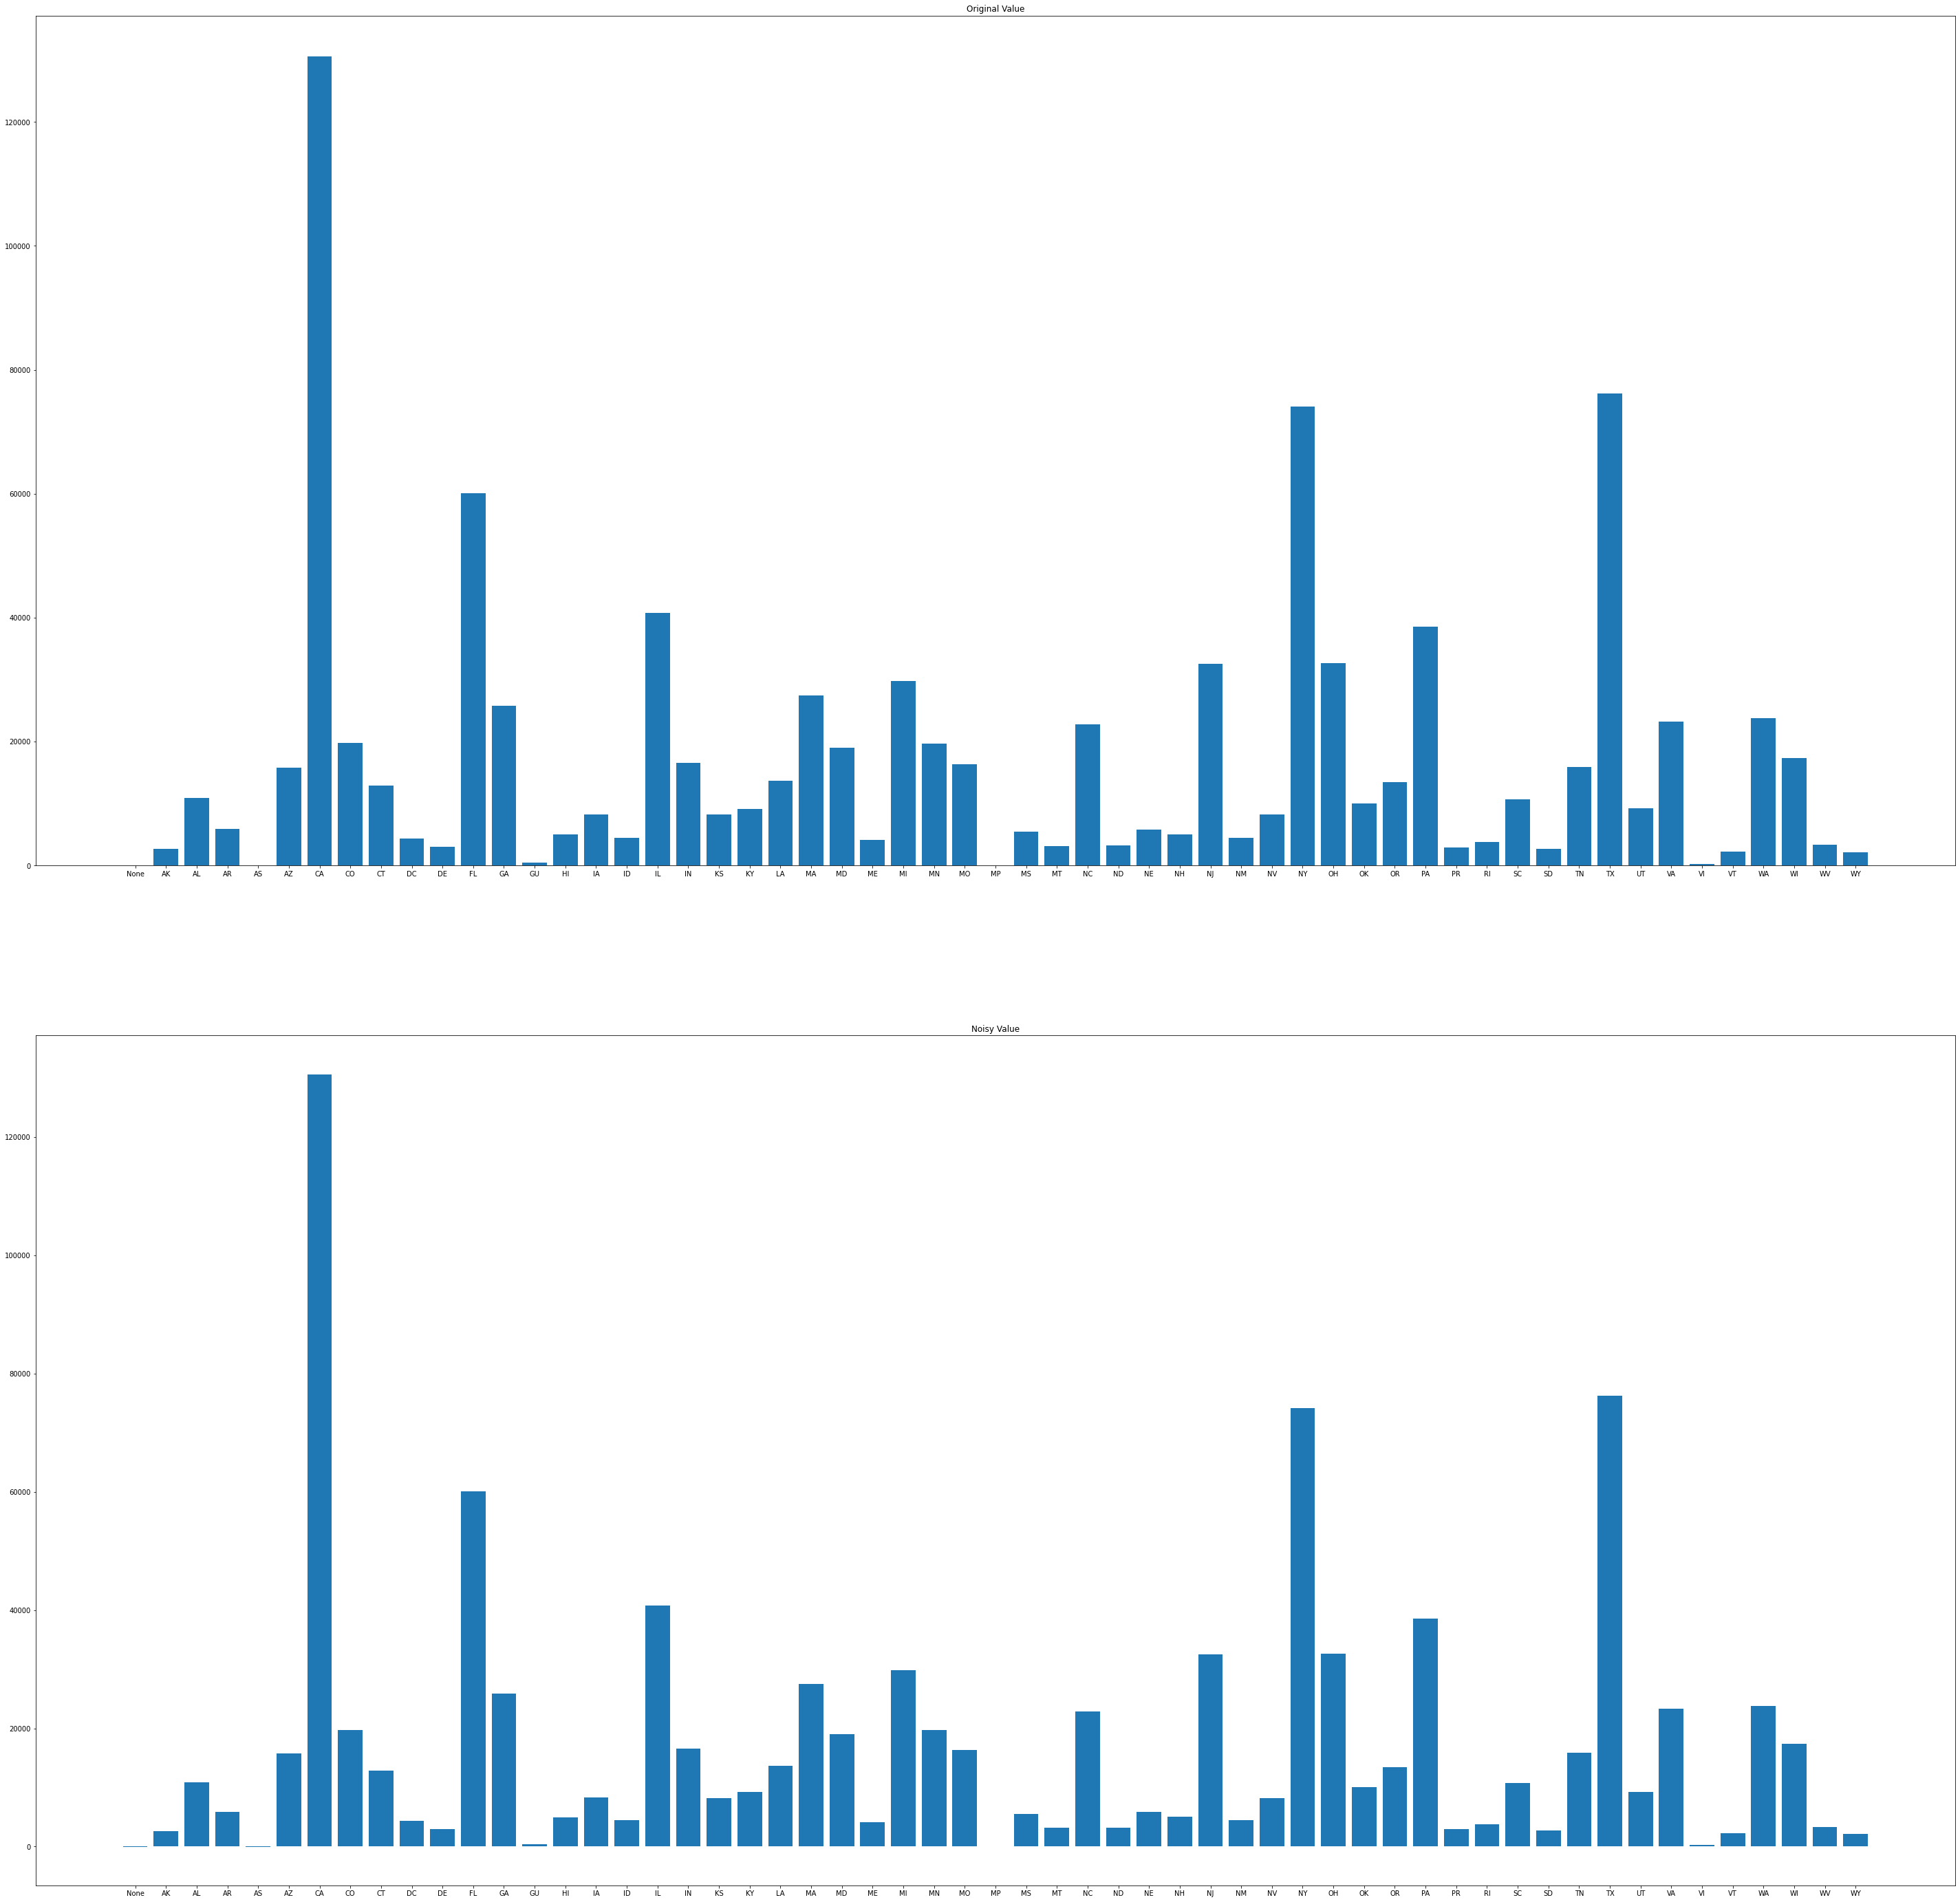

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(50, 50))

category = []; values = []
for result in parallel_query1_result_orig["result"]:
    category.append(str(result[0])); values.append(result[1])

axs[0].bar(category, values)
axs[0].title.set_text("Original Value")

category = []; values = []
for result in parallel_query1_result_diff["result"]:
    category.append(str(result[0])); values.append(result[1])

axs[1].bar(category, values)
axs[1].title.set_text("Noisy Value")

plt.show()

### Query 2

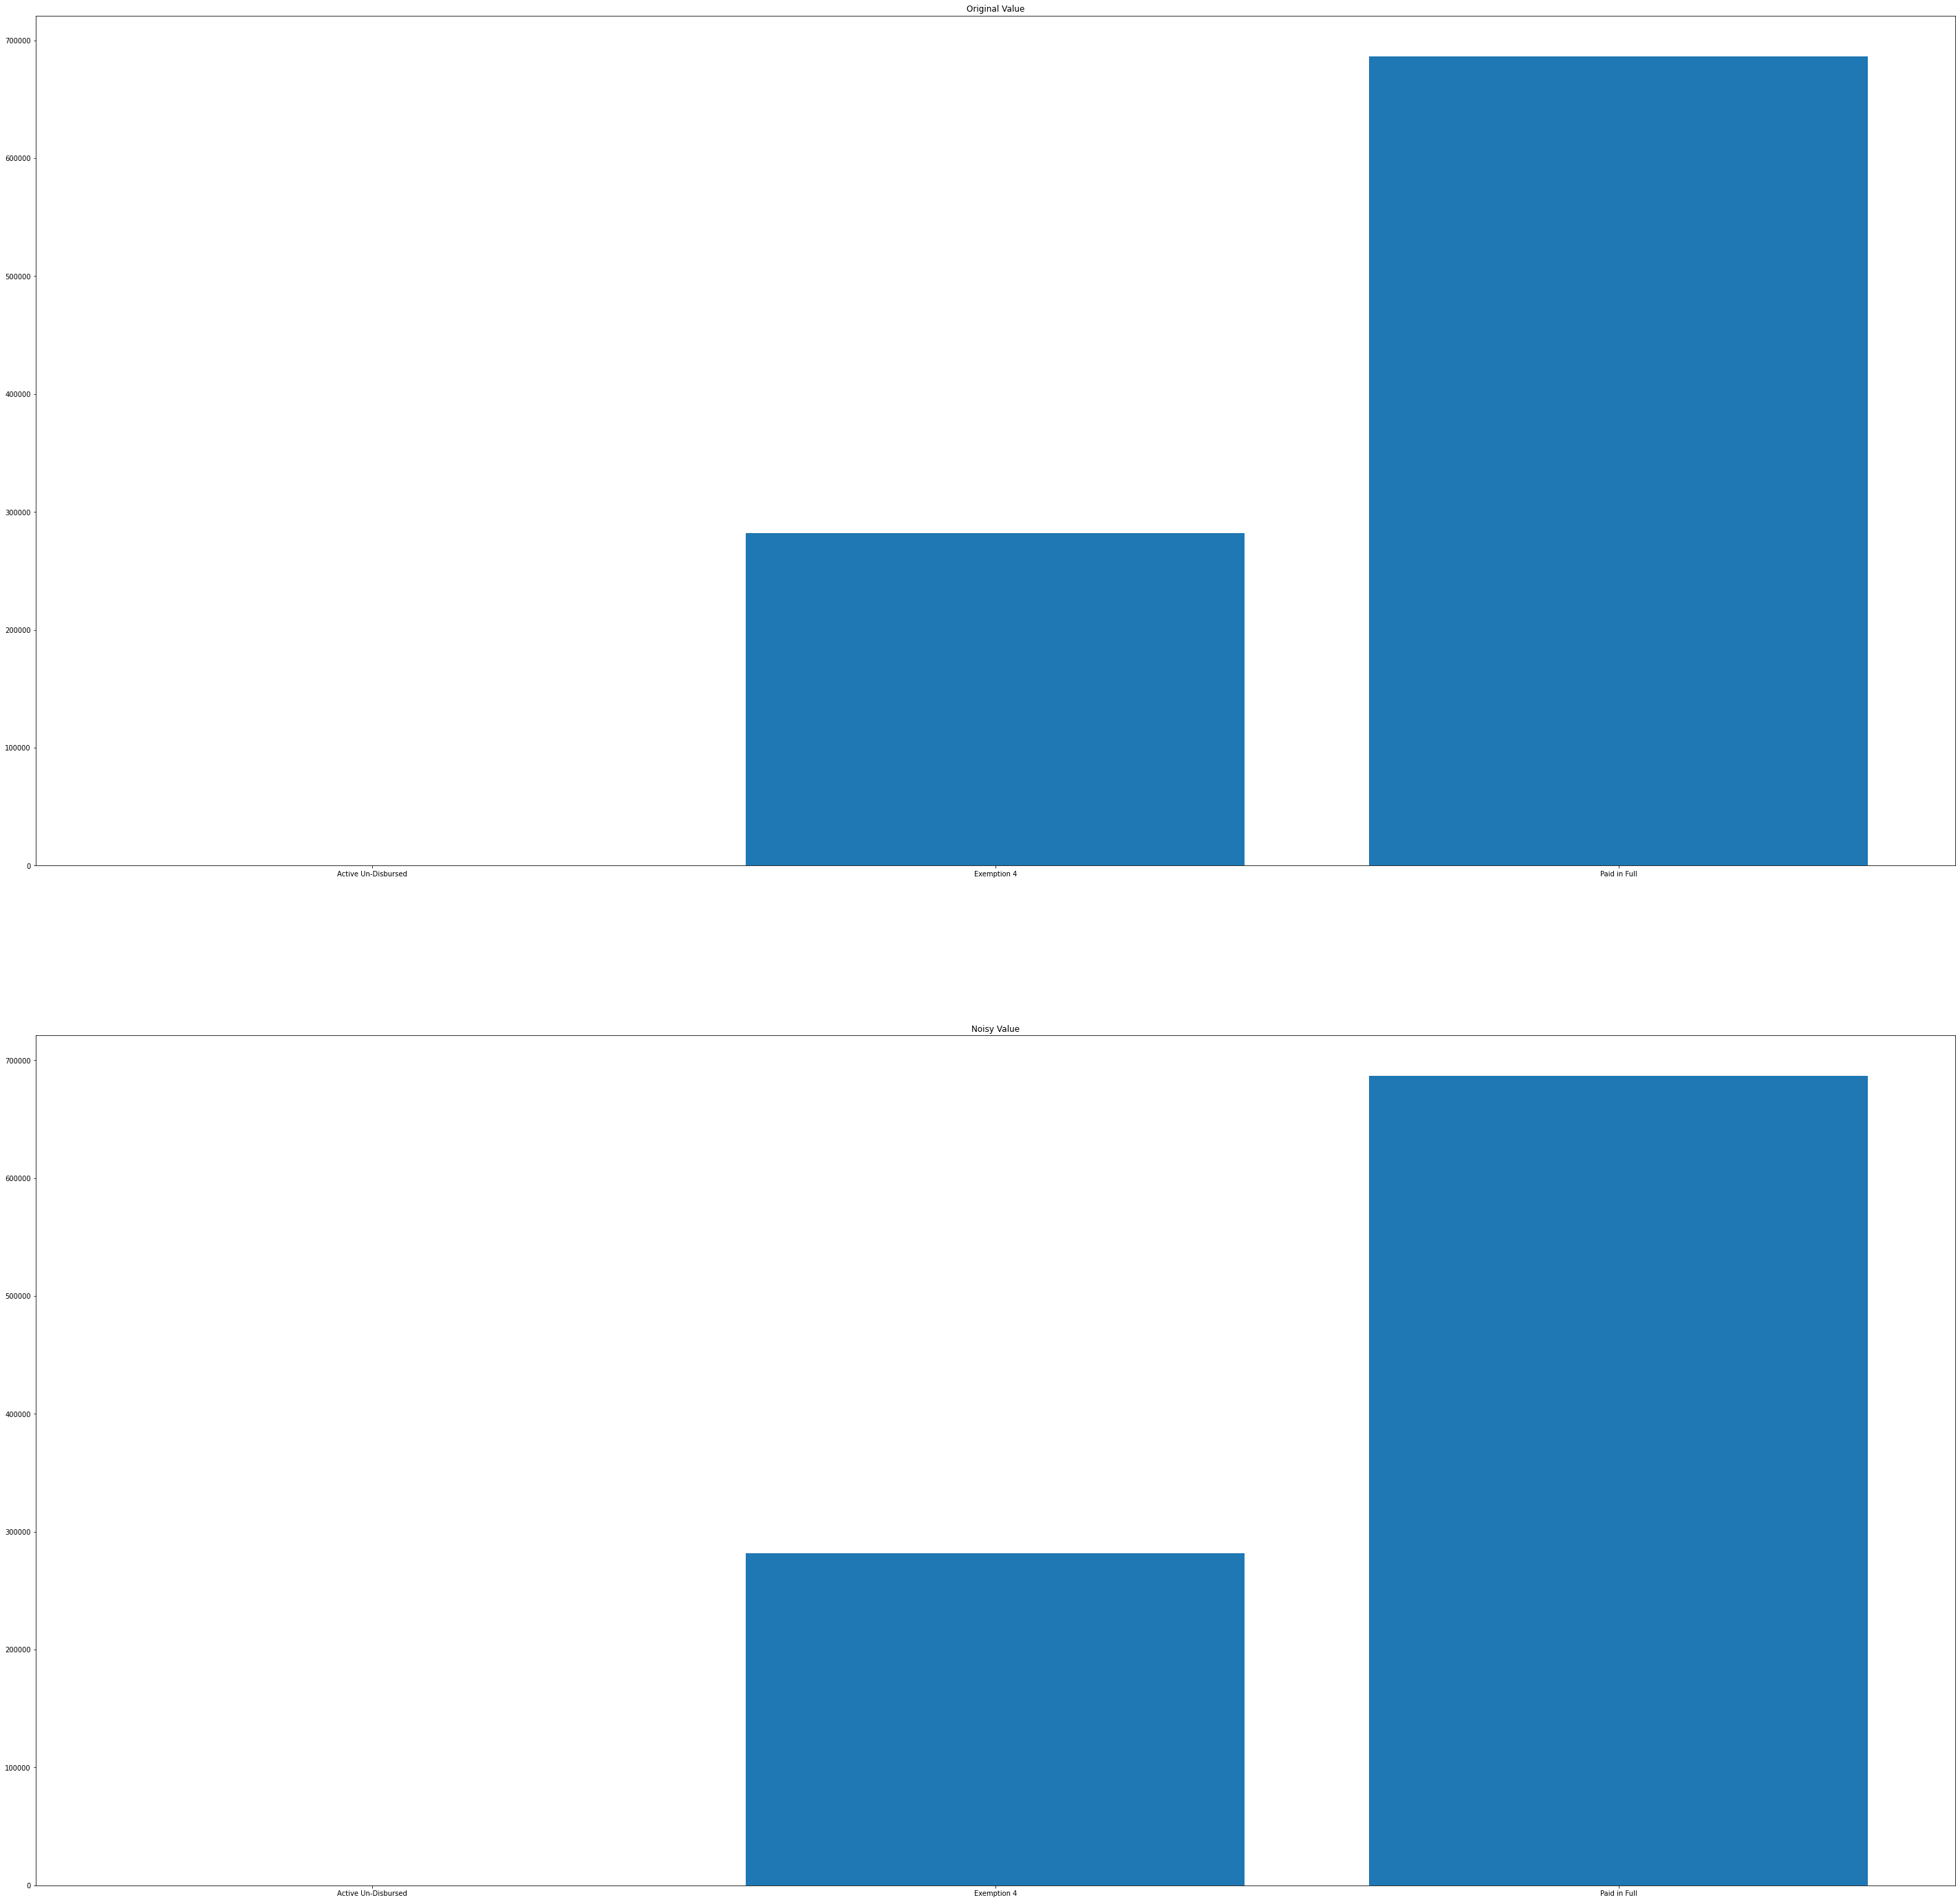

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(50, 50))

category = []; values = []
for result in parallel_query2_result_orig["result"]:
    category.append(str(result[0])); values.append(result[1])

axs[0].bar(category, values)
axs[0].title.set_text("Original Value")

category = []; values = []
for result in parallel_query2_result_diff["result"]:
    category.append(str(result[0])); values.append(result[1])

axs[1].bar(category, values)
axs[1].title.set_text("Noisy Value")

plt.show()

### Query 3

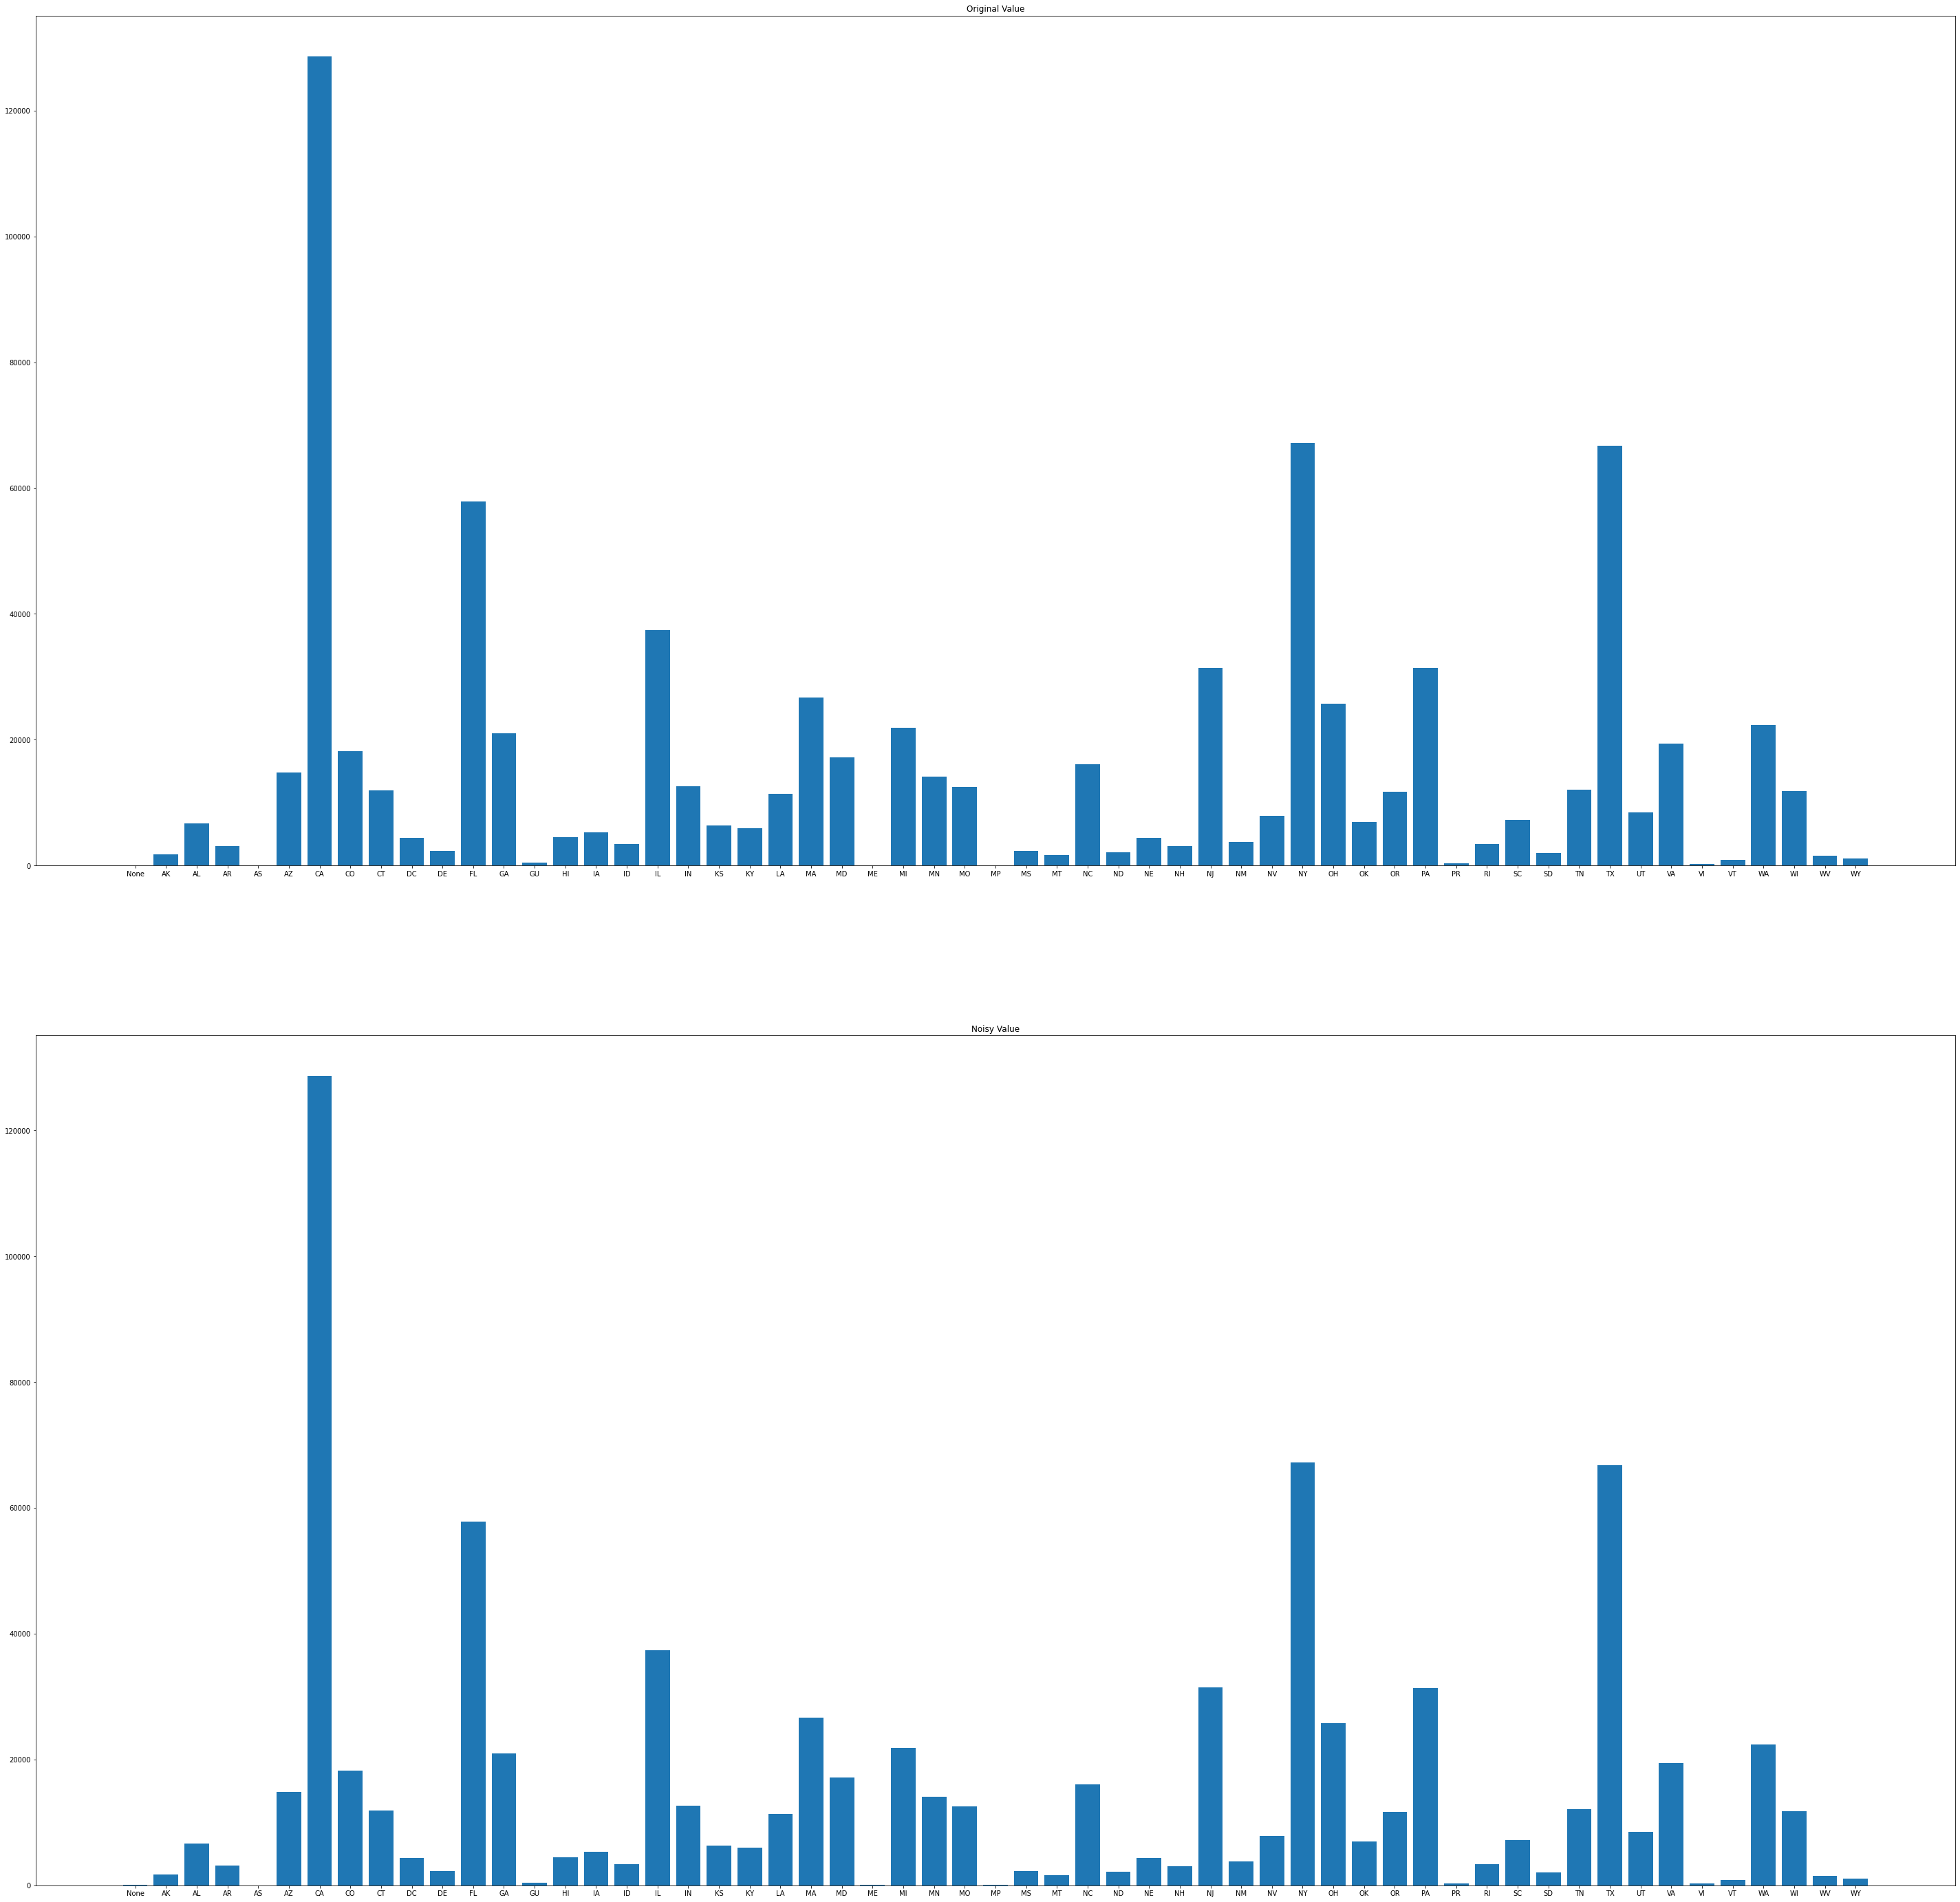

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(50, 50))

category = []; values = []
for result in parallel_query3_result_orig["result"]:
    category.append(str(result[0])); values.append(result[1])

axs[0].bar(category, values)
axs[0].title.set_text("Original Value")

category = []; values = []
for result in parallel_query3_result_diff["result"]:
    category.append(str(result[0])); values.append(result[1])

axs[1].bar(category, values)
axs[1].title.set_text("Noisy Value")

plt.show()